In [32]:
#!pip install validators
#!pip install torch torchvision torchaudio
#!pip install wget
#%pip uninstall --yes torch torchvision torchaudio
#%pip install torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu115
#%pip install torchinfo

In [33]:
import torch
import torchvision.transforms as transforms
from torchvision import datasets, models
import torch.nn as nn
from torch.nn import functional as F
import torch.optim as optim
import torchvision.utils as vutils

from PIL import Image
import numpy as np
import json
import requests
import matplotlib.pyplot as plt
import warnings
import os
import cv2
import shutil
from collections import Counter
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

warnings.filterwarnings('ignore')
%matplotlib inline

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Using {device} for inference')

Using cuda for inference


In [34]:
resnet50 = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_resnet50', pretrained=True)
utils = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_convnets_processing_utils')

resnet50.eval().to(device)

Using cache found in C:\Users\kuo19/.cache\torch\hub\NVIDIA_DeepLearningExamples_torchhub
Using cache found in C:\Users\kuo19/.cache\torch\hub\NVIDIA_DeepLearningExamples_torchhub


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layers): Sequential(
    (0): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0): Conv2d

In [35]:
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

resnet50.fc = nn.Sequential(
               nn.Linear(2048, 36),
               nn.Dropout(p=0.02),
               nn.ReLU(inplace=True),
               nn.Linear(36, 36),
               nn.Softmax()).to(device)                                             

torch.autograd.set_detect_anomaly(True)               


In [36]:
DATADIR = "BeeMachine_quarter"
CATEGORIES = ["Bombus_affinis", "Bombus_appositus", "Bombus_auricomus", "Bombus_bifarius", "Bombus_bimaculatus", "Bombus_borealis", 
             "Bombus_caliginosus", "Bombus_centralis", "Bombus_citrinus", "Bombus_crotchii", "Bombus_cryptarum", "Bombus_fernaldae_flavidus", 
             "Bombus_fervidus_californicus", "Bombus_flavifrons", "Bombus_fraternus", "Bombus_frigidus", "Bombus_griseocollis", "Bombus_huntii", 
             "Bombus_impatiens", "Bombus_insularis", "Bombus_melanopygus", "Bombus_mixtus", "Bombus_morrisoni", "Bombus_nevadensis", 
             "Bombus_occidentalis", "Bombus_pensylvanicus_sonorus", "Bombus_perplexus","Bombus_rufocinctus", "Bombus_sandersoni",
             "Bombus_sitkensis", "Bombus_sylvicola", "Bombus_ternarius", "Bombus_terricola", "Bombus_vagans", "Bombus_vandykei", 
             "Bombus_vosnesenskii"]

Import Data

In [37]:
import os

dataset = {}

def create_dataset():
    image_cap = 400
    for category in CATEGORIES:
        img_filenames = []
        path = os.path.join(DATADIR,category)
        cnt = 0  
        for img in os.listdir(path):
            try:
                img_filenames.append(os.path.join(path,img))
                cnt = cnt + 1
            except Exception as e:
                pass
            if cnt >= image_cap:
                break
        dataset[category] = img_filenames
        
create_dataset()


Separate data to train and validation dataset

In [38]:
def deleteFolder(pathToDelete):
    try:
        dir_path = os.path.join(DATADIR,pathToDelete)
        shutil.rmtree(dir_path)
    except OSError as e:
        print("Error: %s : %s" % (dir_path, e.strerror))

In [39]:

training_list = []
def separate_train_and_validate_dataset(dataset, training_list):
    for category in dataset:
        img_file_train, img_file_test = train_test_split(dataset[category], test_size=0.2, random_state=42)
        #deleteFolder('train')
        trainPath = os.path.join(DATADIR,'train',category)
        isExist = os.path.exists(trainPath)
        if not isExist:
            # Create a new directory because it does not exist 
            os.makedirs(trainPath)
            #print("The new directory {} is created!".format(trainPath))
        for f in img_file_train:
            shutil.copy(f, trainPath)
        training_list.append(category)
        #deleteFolder('validation')
        validationPath = os.path.join(DATADIR,'validation',category)
        isExist = os.path.exists(validationPath)
        if not isExist:
            # Create a new directory because it does not exist 
            os.makedirs(validationPath)
            #print("The new directory {} is created!".format(validationPath))

        for f in img_file_test:
            shutil.copy(f, validationPath)
                
separate_train_and_validate_dataset(dataset, training_list)

In [40]:
data_transforms = {
    'train':
    transforms.Compose([
        transforms.Resize((299,299)),
        transforms.RandomAffine(0, shear=10, scale=(0.8,1.2)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor()
    ]),
    'validation':
    transforms.Compose([
        transforms.Resize((299,299)),
        transforms.ToTensor()
    ]),
}

image_datasets = {
    'train': 
    datasets.ImageFolder(DATADIR + '\\train', data_transforms['train']),
    'validation': 
    datasets.ImageFolder(DATADIR + '\\validation', data_transforms['validation'])
}

dataloaders = {
    'train':
    torch.utils.data.DataLoader(image_datasets['train'],
                                batch_size=32,
                                shuffle=True,
                                num_workers=0),  # for Kaggle
    'validation':
    torch.utils.data.DataLoader(image_datasets['validation'],
                                batch_size=32,
                                shuffle=False,
                                num_workers=0)  # for Kaggle
}

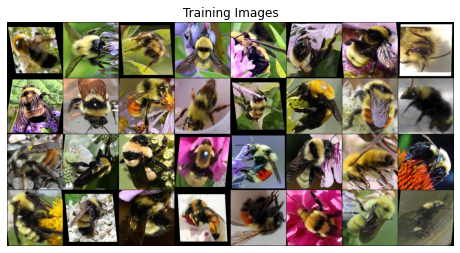

In [41]:
# Plot some training images
real_batch = next(iter(dataloaders['train']))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

In [42]:

weights = class_weight.compute_class_weight('balanced', np.unique(training_list), training_list)
class_weights=torch.tensor(weights,dtype=torch.float).to(device)

criterion = nn.CrossEntropyLoss(class_weights)
optimizer = optim.SGD(resnet50.fc.parameters(), lr=0.0001, momentum=0.9)

In [43]:
n_epochs = 1
valid_loss_min = np.Inf
val_loss = []
val_acc = []
train_loss = []
train_acc = []
total_step = len(dataloaders['train'])

def train_model_new(model, dataloaders, criterion, optimizer, valid_loss_min, val_loss, val_acc
                , train_loss, train_acc, total_step, num_epochs=3):
    for epoch in range(1, n_epochs+1):
        running_loss = 0.0
        correct = 0
        total=0
        print(f'Epoch {epoch}\n')
        for batch_idx, (data_, target_) in enumerate(dataloaders['train']):
            data_, target_ = data_.to(device), target_.to(device)
            optimizer.zero_grad()
            
            outputs = model(data_)
            loss = criterion(outputs, target_)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _,pred = torch.max(outputs, dim=1)
            correct += torch.sum(pred==target_).item()
            total += target_.size(0)
            print("matrix predict {} target {}".format(pred, target_))
            if (batch_idx) % 20 == 0:
                print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                    .format(epoch, n_epochs, batch_idx, total_step, loss.item()))
        train_acc.append(100 * correct / total)
        train_loss.append(running_loss/total_step)
        print(f'\ntrain-loss: {np.mean(train_loss):.4f}, train-acc: {(100 * correct/total):.4f}')
        batch_loss = 0
        total_t=0
        correct_t=0
        with torch.no_grad():
            model.eval()
            for data_t, target_t in (dataloaders['validation']):
                data_t, target_t = data_t.to(device), target_t.to(device)
                outputs_t = model(data_t)
                loss_t = criterion(outputs_t, target_t)
                batch_loss += loss_t.item()
                _,pred_t = torch.max(outputs_t, dim=1)
                #print("predict {} target {}".format(len(pred_t), len(target_t)))
                print("matrix predict {} target {}".format(pred_t, target_t))
                correct_t += torch.sum(pred_t==target_t).item()
                total_t += target_t.size(0)
            val_acc.append(100 * correct_t/total_t)
            val_loss.append(batch_loss/len(dataloaders['validation']))
            network_learned = batch_loss < valid_loss_min
            print(f'validation loss: {np.mean(val_loss):.4f}, validation acc: {(100 * correct_t/total_t):.4f}\n')
            show_confusion_matrix(model, target_t, pred_t)
            
            if network_learned:
                modelPath = 'models/pytorch'
                isExist = os.path.exists(modelPath)
                if not isExist:
                    # Create a new directory because it does not exist 
                    os.makedirs(modelPath)
                    print("The new directory {} is created!".format(modelPath))
                valid_loss_min = batch_loss
                torch.save(model.state_dict(), 'models/pytorch/traiend_resnet50.h5')
                print('Improvement-Detected, save-model')
        model.train()
    return model



In [46]:
model_trained = train_model_new(resnet50, dataloaders, criterion, optimizer, valid_loss_min, val_loss, val_acc, train_loss, train_acc, total_step, n_epochs)

Epoch 1

Epoch [1/1], Step [0/330], Loss: 3.5828
Epoch [1/1], Step [20/330], Loss: 3.5829
Epoch [1/1], Step [40/330], Loss: 3.5822
Epoch [1/1], Step [60/330], Loss: 3.5839
Epoch [1/1], Step [80/330], Loss: 3.5833
Epoch [1/1], Step [100/330], Loss: 3.5826
Epoch [1/1], Step [120/330], Loss: 3.5832
Epoch [1/1], Step [140/330], Loss: 3.5846
Epoch [1/1], Step [160/330], Loss: 3.5828
Epoch [1/1], Step [180/330], Loss: 3.5833
Epoch [1/1], Step [200/330], Loss: 3.5832
Epoch [1/1], Step [220/330], Loss: 3.5834
Epoch [1/1], Step [240/330], Loss: 3.5828
Epoch [1/1], Step [260/330], Loss: 3.5824
Epoch [1/1], Step [280/330], Loss: 3.5811
Epoch [1/1], Step [300/330], Loss: 3.5840
Epoch [1/1], Step [320/330], Loss: 3.5842

train-loss: 3.5832, train-acc: 2.9138
matrix predict tensor([34, 13, 34, 13, 34, 13,  2, 13, 13, 13, 34, 32, 13, 34, 34, 34,  2, 34,
        34, 13, 32, 32, 13, 13, 32, 13, 13, 13, 13, 34, 34, 13],
       device='cuda:0') target tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

Save Model

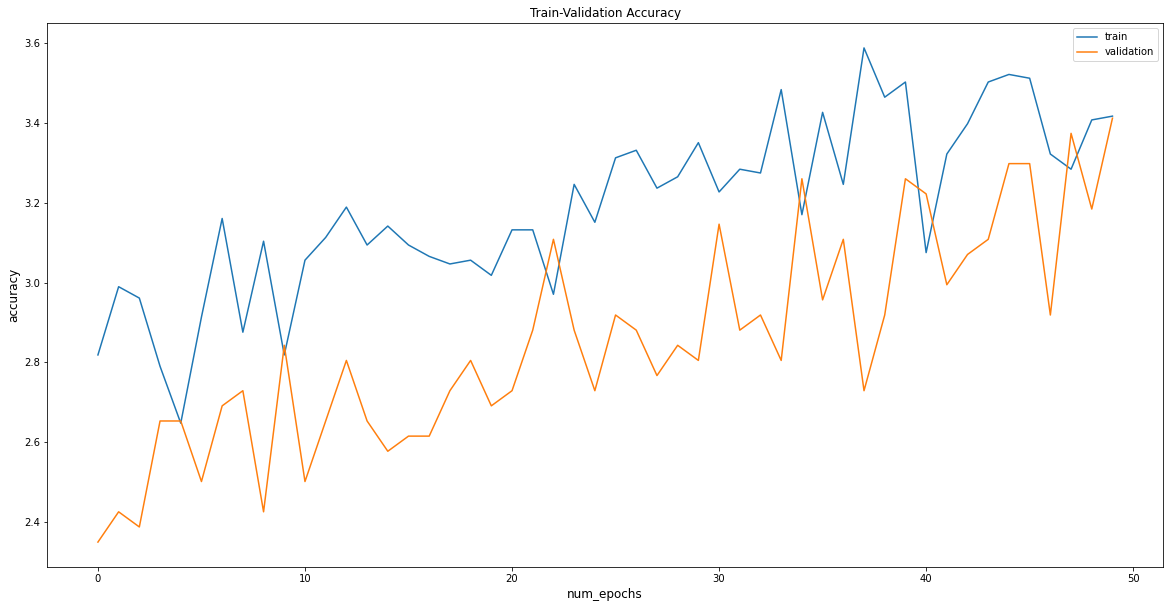

In [14]:
fig = plt.figure(figsize=(20,10))
plt.title("Train-Validation Accuracy")
plt.plot(train_acc, label='train')
plt.plot(val_acc, label='validation')
plt.xlabel('num_epochs', fontsize=12)
plt.ylabel('accuracy', fontsize=12)
plt.legend(loc='best')

In [ ]:
resnet50 = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_resnet50', pretrained=False)
resnet50.load_state_dict(torch.load('models/pytorch/traiend_resnet50.h5'))                 

Using cache found in C:\Users\kuo19/.cache\torch\hub\NVIDIA_DeepLearningExamples_torchhub


RuntimeError: Error(s) in loading state_dict for ResNet:
	Missing key(s) in state_dict: "fc.weight", "fc.bias". 
	Unexpected key(s) in state_dict: "fc.0.weight", "fc.0.bias", "fc.3.weight", "fc.3.bias". 

In [45]:
def show_confusion_matrix(model, targets, train_preds):
   cmt = torch.zeros(36,36, dtype=torch.int64)
   stacked = torch.stack(
        (
            targets
            ,train_preds
        )
   )
   print(stacked)
   print(stacked.shape)
   


#    for p in stacked:
#        tl, pl = p.tolist()
#        cmt[tl, pl] = cmt[tl, pl] + 1
#    print(cmt) 



## OVER SAMPLEING ## 


TEST Github+
TRY +1


## Yelei Test